In [1]:
import argparse
import os
import csv
import random
import time
import json
import math
from collections import defaultdict

from scipy.spatial.transform import Rotation as R

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## Load data

In [2]:
training_traj = np.load(f'./npys/training_traj_0.6.npy')
validation_traj = np.load(f'./npys/all_user_match_data.npy', allow_pickle=True)

In [3]:
def estimate_gravity(gravity_included_acceleration, dynamic_acceleration):
    raw_gravity_vector = np.array(gravity_included_acceleration) - np.array(dynamic_acceleration)
    gravity_direction = raw_gravity_vector / np.linalg.norm(raw_gravity_vector)
    return gravity_direction

In [4]:
def align_magnetometer_with_gravity(magnetometer_data, gravity_direction):
    target_gravity_direction = np.array([0, 0, 1])
    rotation_vector = np.cross(gravity_direction, target_gravity_direction)
    rotation_vector_magnitude = np.linalg.norm(rotation_vector)
    if rotation_vector_magnitude == 0:
        return magnetometer_data  # 如果已经对齐，则不需要旋转
    rotation_vector /= rotation_vector_magnitude
    angle = np.arccos(np.dot(gravity_direction, target_gravity_direction))
    rotation = R.from_rotvec(rotation_vector * angle[:, np.newaxis])
    rotated_magnetometer_data = rotation.apply(magnetometer_data)
#     vh = np.column_stack((np.sqrt(rotated_magnetometer_data[:, 0]**2 + rotated_magnetometer_data[:, 1]**2), rotated_magnetometer_data[:, 2]))
    return rotated_magnetometer_data

In [5]:
def get_data(validation_traj, rotation):
    posture_data = defaultdict(list)

    valid_data = validation_traj.item()
    for user_name in valid_data.keys():
        for path_name in valid_data[user_name].keys():
            for posture_name in valid_data[user_name][path_name].keys():
                data = valid_data[user_name][path_name][posture_name]

                if posture_name == 'ref_mag':
                    posture_data[posture_name].append(data[:, [0, 1, 2, 3, 4, 5]])
                    continue

                pos = data[:, [0, 1]]
                imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
                mag = data[:, [12, 13, 14]]

                pos_mag = np.concatenate((pos, imu), axis=-1)

                if rotation:
                    gravity_direction = estimate_gravity(imu[:, 0:3], imu[:, 3:6])
                    mag = align_magnetometer_with_gravity(mag[:, 0:3], gravity_direction)
                
                pos_mag = np.concatenate((pos_mag, mag, data[:, [15]]), axis=-1)            
                posture_data[posture_name].append(pos_mag)
    return posture_data

In [6]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [7]:
def expand_seq_features(seq, imu=False):
    ### neighbors
    s_cord = seq[:, :, 0:2]
    if imu:
        s_imu = seq[:, :, 2:11]
    s_mag = seq[:, :, -4:-1]
    s_magT = seq[:, :, [-1]]
    
    s_magH = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2))  # magH
    s_magV = s_mag[:, :, 2]
    s_elevation_angle = np.arccos(s_magH / s_magT) / np.pi * 180  # angle
    # n_azimuth_angle = 0
    
    print(s_cord.shape, s_mag.shape, s_magT.shape, s_magH.shape, s_elevation_angle.shape, end=' ')
    if imu:
        s_new = np.concatenate([s_cord, s_imu, s_mag, s_magH, s_magT, s_elevation_angle], axis=-1)
    else:
        s_new = np.concatenate([s_cord, s_mag, s_magH, s_magT, s_elevation_angle], axis=-1)
    print(s_new.shape)
    return s_new

In [8]:
rotation = True
posture_data = get_data(validation_traj, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['training']     = expand_seq_features(split_traj(training_traj))
prep_valid_traj['front_pocket'] = expand_seq_features(split_traj(posture_data['front_pocket']), True)
prep_valid_traj['pocket']       = expand_seq_features(split_traj(posture_data['pocket']), True)
prep_valid_traj['swing']        = expand_seq_features(split_traj(posture_data['swing']), True)
prep_valid_traj['target']       = expand_seq_features(split_traj(posture_data['target']), True)
prep_valid_traj['ref_mag']      = expand_seq_features(split_traj(posture_data['ref_mag']))

(310000, 20, 2) (310000, 20, 3) (310000, 20, 1) (310000, 20, 1) (310000, 20, 1) (310000, 20, 8)
(674, 20, 2) (674, 20, 3) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 17)
(674, 20, 2) (674, 20, 3) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 17)
(674, 20, 2) (674, 20, 3) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 17)
(674, 20, 2) (674, 20, 3) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 17)
(674, 20, 2) (674, 20, 3) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 8)


## Create Dataset & Dataloader

In [9]:
class SequenceDataset(Dataset):
    def __init__(self, sequence, pos, imu=None):
        self.sequence = sequence
        self.imu = imu
        self.pos = pos

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        if self.imu != None: 
            return self.sequence[idx], self.pos[idx], self.imu[idx]
        return self.sequence[idx], self.pos[idx]

In [10]:
### train dataloader ###
train_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_traj['training'][:, :, -6:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_traj['training'][:, -1, :2], dtype=torch.float)
                )
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

test_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_traj['ref_mag'][:, :, -6:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_traj['ref_mag'][:, -1, :2], dtype=torch.float)
                )
test_loader = DataLoader(test_dataset, batch_size=32)


### test dataloader ###
front_pocket_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_traj['front_pocket'][:, :, -6:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_traj['front_pocket'][:, -1, :2], dtype=torch.float),
                    imu=torch.tensor(prep_valid_traj['front_pocket'][:, :, 2:11], dtype=torch.float)
                )
front_pocket_loader = DataLoader(front_pocket_dataset, batch_size=32)

pocket_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_traj['pocket'][:, :, -6:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_traj['pocket'][:, -1, :2], dtype=torch.float),
                    imu=torch.tensor(prep_valid_traj['pocket'][:, :, 2:11], dtype=torch.float)
                )
pocket_loader = DataLoader(pocket_dataset, batch_size=32)

swing_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_traj['swing'][:, :, -6:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_traj['swing'][:, -1, :2], dtype=torch.float),
                    imu=torch.tensor(prep_valid_traj['swing'][:, :, 2:11], dtype=torch.float)
                )
swing_loader = DataLoader(swing_dataset, batch_size=32)

target_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_traj['target'][:, :, -6:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_traj['target'][:, -1, :2], dtype=torch.float),
                    imu=torch.tensor(prep_valid_traj['target'][:, :, 2:11], dtype=torch.float)
                )
target_loader = DataLoader(target_dataset, batch_size=32)

## Model

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(9, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 9),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = self.mag_last(pred_latent)
        
        return z_imu, pred_mag
        

In [12]:
class Locator(nn.Module):
    def __init__(self, seq_len=60):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=6, hidden_size=32, num_layers=3, batch_first=True, bidirectional=False)
        
        self.last = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 2),
        )
        
    def forward(self, features):
        h, _ = self.lstm(features)
        
        pos = self.last(h[:, -1])
        
        return pos

In [13]:
def train(dataloader):
    model.train()

    mse_loss = []
    l1_loss = []

    for sequences, gt_pos in dataloader:
        optimizer.zero_grad()
        
        sequences = sequences.to(device)
        gt_pos = gt_pos.to(device)
        
        # localization
        pred_pos = model(sequences + torch.randn_like(sequences) * 0.25)
        
        # loss
        loss = MSE_Loss(pred_pos, gt_pos)
        
        # backward
        loss.backward()
        optimizer.step()
        
        # record loss
        mse_loss.append(loss.item())
        l1_loss.append(L1_loss(pred_pos, gt_pos).item())
    
    return np.mean(mse_loss), np.mean(l1_loss)

In [14]:
def evaluate(dataloader, calibrate=False):
    model.eval()

    mse_loss = []
    l1_loss = []

    with torch.no_grad():
        for sequences, gt_pos in dataloader:
            optimizer.zero_grad()
            
            sequences = sequences.to(device)
            gt_pos = gt_pos.to(device)

            # localization
            pred_pos = model(sequences)

            # loss
            loss = MSE_Loss(pred_pos, gt_pos)

            # record loss
            mse_loss.append(loss.item())
            l1_loss.append(L1_loss(pred_pos, gt_pos).item())
    
    return np.mean(mse_loss), np.mean(l1_loss)

In [16]:
EPOCH = 20000
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
MSE_Loss = torch.nn.MSELoss()
L1_loss = torch.nn.L1Loss()

In [17]:
model = Locator()
calibration = torch.load('/root/Calibration/R403/model/0515_ft_rotation/transformer_3_1.pt').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000075)

In [19]:
cp = torch.load('/root/Calibration/R403/model/Localization/localizator_EPOCH10000.pt')
model.load_state_dict(cp['model_state_dict'])

<All keys matched successfully>

In [20]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000075)
optimizer.load_state_dict(cp['optimizer_state_dict'])

In [21]:
from torchinfo import summary
summary(model, input_size=[(1, 20, 6)])

Layer (type:depth-idx)                   Output Shape              Param #
Locator                                  [1, 2]                    --
├─LSTM: 1-1                              [1, 20, 32]               22,016
├─Sequential: 1-2                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 16]                   528
│    └─LeakyReLU: 2-2                    [1, 16]                   --
│    └─Linear: 2-3                       [1, 8]                    136
│    └─LeakyReLU: 2-4                    [1, 8]                    --
│    └─Linear: 2-5                       [1, 2]                    18
Total params: 22,698
Trainable params: 22,698
Non-trainable params: 0
Total mult-adds (M): 0.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.09
Estimated Total Size (MB): 0.10

In [23]:
summary(calibration, input_size=[(1, 20, 9), [1, 20, 3]])

Layer (type:depth-idx)                        Output Shape              Param #
NotSimpleTransformer                          [1, 20, 9]                --
├─Sequential: 1-1                             [1, 20, 64]               --
│    └─Linear: 2-1                            [1, 20, 32]               320
│    └─LeakyReLU: 2-2                         [1, 20, 32]               --
│    └─Linear: 2-3                            [1, 20, 64]               2,112
│    └─LeakyReLU: 2-4                         [1, 20, 64]               --
├─PositionalEncoding: 1-2                     [1, 20, 64]               --
│    └─Dropout: 2-5                           [1, 20, 64]               --
├─Sequential: 1-3                             [1, 20, 64]               --
│    └─Linear: 2-6                            [1, 20, 16]               64
│    └─LeakyReLU: 2-7                         [1, 20, 16]               --
│    └─Linear: 2-8                            [1, 20, 64]               1,088
│    └─LeakyR

In [ ]:
pos=['train', 'valid', 'front pocket', 'target', 'pocket', 'swing']
for epoch in tqdm(range(EPOCH)):
    
    train_loss, train_l1 = train(train_loader)
#     train_loss, train_l1 = train(target_loader)
    
    if (epoch + 1) % 1000 == 0:
        ep = str(epoch + 1).zfill(5)
        valid_loss, valid_l1 = evaluate(test_loader) 
        print(f'{ep:>5}:   {pos[0]:>13} mse loss: {train_loss:>6.3f}, l1 loss: {train_l1:>6.3f}\t      valid mse loss: {valid_loss:>6.3f}, l1 loss: {valid_l1:>6.3f}')
        torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': (train_loss, train_l1),
            }, f'./model/Localization/localizator_EPOCH{epoch+1:05d}.pt')
#         print(f'         {pos[2]:>13} mse loss: {front_pocket_loss:>6.3f}, l1 loss: {front_pocket_l1:>6.3f}\t calibrated mse loss: {c_front_pocket_loss:>6.3f}, l1 loss: {c_front_pocket_l1:>6.3f}')
#         print(f'         {pos[3]:>13} mse loss: {horizontal_loss:>6.3f}, l1 loss: {horizontal_l1:>6.3f}\t calibrated mse loss: {c_horizontal_loss:>6.3f}, l1 loss: {c_horizontal_l1:>6.3f}')
#         print(f'         {pos[4]:>13} mse loss: {pocket_loss:>6.3f}, l1 loss: {pocket_l1:>6.3f}\t calibrated mse loss: {c_pocket_loss:>6.3f}, l1 loss: {c_pocket_l1:>6.3f}')
#         print(f'         {pos[5]:>13} mse loss: {swing_loss:>6.3f}, l1 loss: {swing_l1:>6.3f}\t calibrated mse loss: {c_swing_loss:>6.3f}, l1 loss: {c_swing_l1:>6.3f}')
#         print(f'{ep:>5}:  train mse loss: {train_loss: >6.3f}, l1 loss: {train_l1: >6.3f}     horizontal mse loss: {horizontal_loss: >6.3f}, l1 loss: {horizontal_l1: >6.3f}')  
#         print(f'        swing mse loss: {swing_loss: >6.3f}, l1 loss: {swing_l1: >6.3f}   front_pocket mse loss: {front_pocket_loss: >6.3f}, l1 loss: {front_pocket_l1: >6.3f}')
#         print(f'       pocket mse loss: {pocket_loss: >6.3f}, l1 loss: {pocket_l1: >6.3f}         target mse loss: {target_loss: >6.3f}, l1 loss: {target_l1: >6.3f}')

  2%|█▊                                                                                                              | 325/20000 [13:22<14:10:46,  2.59s/it]

In [22]:
# torch.save({
#     'locator_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     }, f'/root/Mag/Experiments/0712/loc/m_A_gpr_model.pt')

In [33]:
def pred_sequence_pos(dataloader, got_imu=False, calibrate=False):
    model.eval()
    pred_poses = []
    gt_poses = []
    pairs = []
    pp = nn.PairwiseDistance(p=2)
    
    with torch.no_grad():
        if got_imu:
            for sequences, gt_pos, imu in dataloader:
                optimizer.zero_grad()
                sequences = sequences.to(device)
                if calibrate:
                    to_calibrate = sequences[:, :, 0:3]
                    imu = imu.to(device)
                    _, to_calibrate = calibration(imu, to_calibrate)
                    rss = torch.sqrt(torch.sum(torch.pow(to_calibrate[:, :, 0:2], 2), dim=2, keepdim=True))
                    rss2 = torch.sqrt(torch.sum(torch.pow(to_calibrate[:, :, 0:3], 2), dim=2, keepdim=True))
                    to_calibrate = torch.cat((to_calibrate[:, :, :3], rss, rss2), dim=2)
                    ratio = to_calibrate[:, :, 3] / to_calibrate[:, :, 4]
                    acos_values = torch.acos(ratio)
                    degrees = acos_values * 180 / torch.pi
                    degrees = degrees.unsqueeze(2)
                    sequences = torch.cat((to_calibrate, degrees), dim=2)

                gt_pos = gt_pos.to(device)


                # localization
                pred_pos = model(sequences)
                pair = pp(pred_pos, gt_pos)

                gt_poses.extend(gt_pos.detach().cpu().numpy())
                pred_poses.extend(pred_pos.detach().cpu().numpy())
                pairs.extend(pair.detach().cpu().numpy())
        else:
            for sequences, gt_pos,in dataloader:
                optimizer.zero_grad()

                sequences = sequences.to(device)
                gt_pos = gt_pos.to(device)


                # localization
                pred_pos = model(sequences)
                pair = pp(pred_pos, gt_pos)

                gt_poses.extend(gt_pos.detach().cpu().numpy())
                pred_poses.extend(pred_pos.detach().cpu().numpy())
                pairs.extend(pair.detach().cpu().numpy())
    
    return np.array(gt_poses), np.array(pred_poses), np.array(pairs)

In [25]:
def visualize(data_loader, trajectory, skip=50, got_imu=False, calibrate=False):
    gt_poses, pred_poses, pairs = pred_sequence_pos(data_loader, got_imu, calibrate)
    print(gt_poses.shape, pred_poses.shape, pairs.shape, trajectory.shape)
    print(f'Mean: {np.mean(pairs):>6.3f}\tMedian: {np.median(pairs):>6.3f}')
    test_seq = trajectory[::skip, :, :2]

    plt.figure(figsize=(12, 8))

    plt.plot(test_seq[:, :, 1].T, test_seq[:, :, 0].T, alpha=0.25)

    # plt.scatter(test_seq[:, -1, 1], test_seq[:, -1, 0])
    plt.scatter(gt_poses[::skip, 1], gt_poses[::skip, 0])
    plt.scatter(pred_poses[::skip, 1], pred_poses[::skip, 0])


    for i in range(0, len(gt_poses), skip):
        plt.annotate(int(i/skip), (gt_poses[i, 1], gt_poses[i, 0]))
        plt.annotate(int(i/skip), (pred_poses[i, 1], pred_poses[i, 0]))

    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()

(310000, 2) (310000, 2) (310000,) (310000, 20, 8)
Mean:  0.137	Median:  0.081


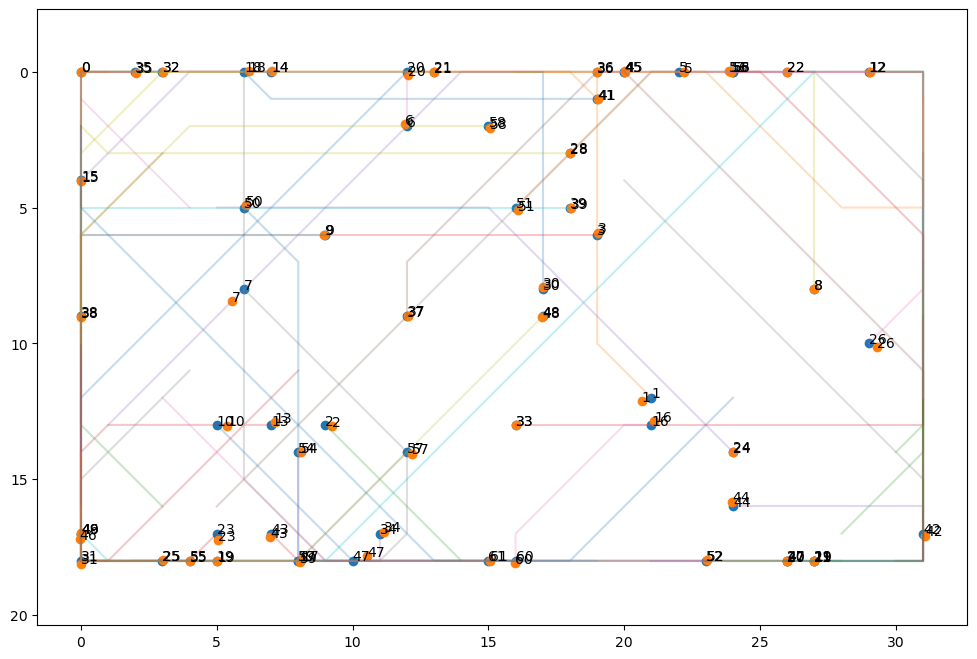

In [25]:
valid_loader = DataLoader(train_dataset, batch_size=32)
visualize(valid_loader,  prep_valid_traj['training'], skip=5000)

(674, 2) (674, 2) (674,) (674, 20, 8)
Mean:  0.402	Median:  0.223


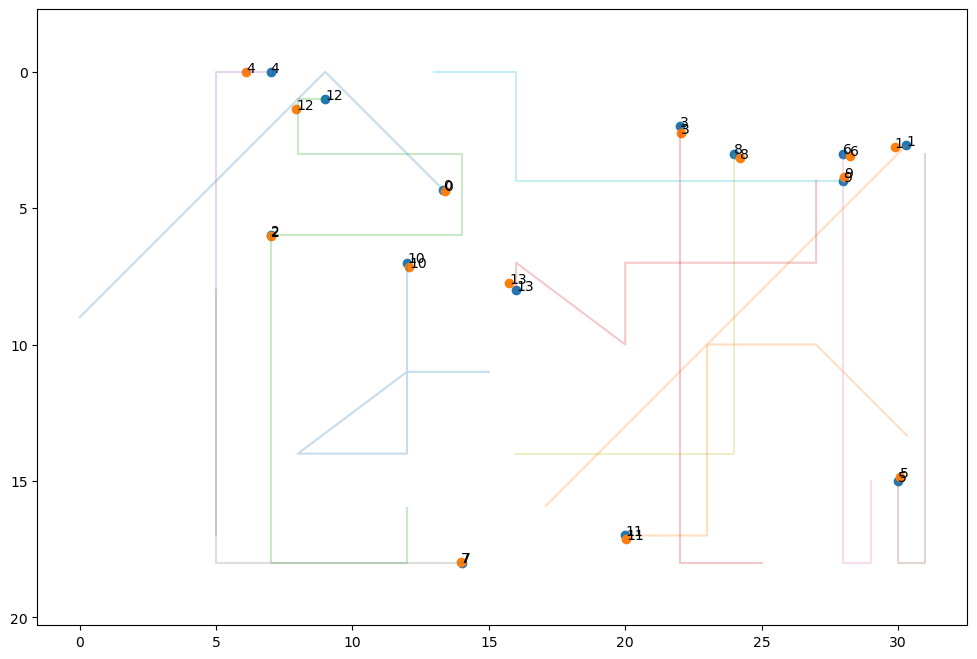

In [26]:
visualize(test_loader, prep_valid_traj['ref_mag'])

(674, 2) (674, 2) (674,) (674, 20, 17)
Mean: 11.110	Median: 10.213


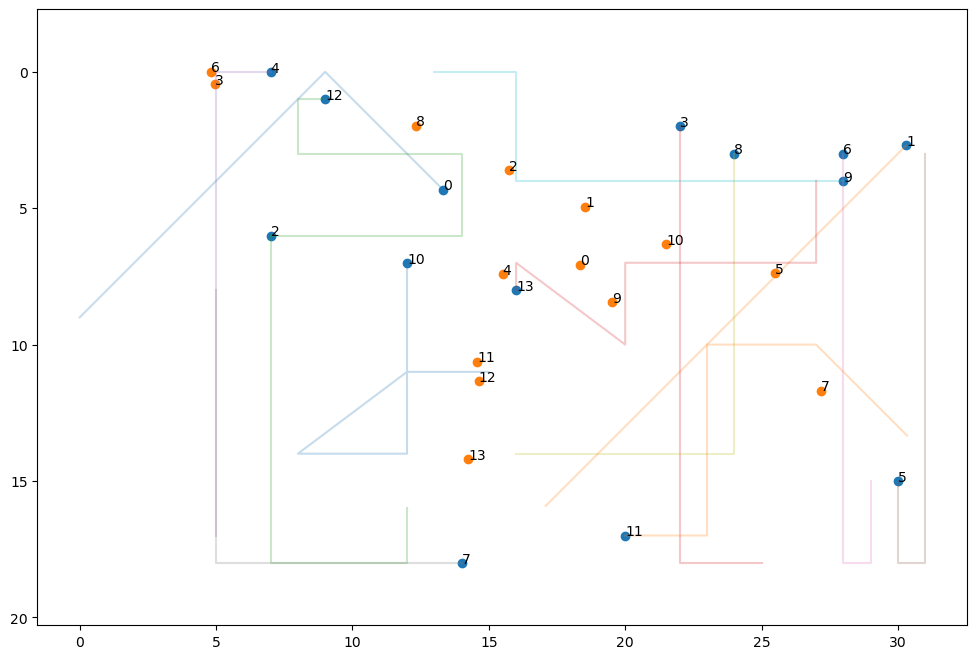

In [27]:
visualize(front_pocket_loader, prep_valid_traj['front_pocket'], got_imu=True, calibrate=False)

(674, 2) (674, 2) (674,) (674, 20, 17)
Mean:  2.065	Median:  0.836


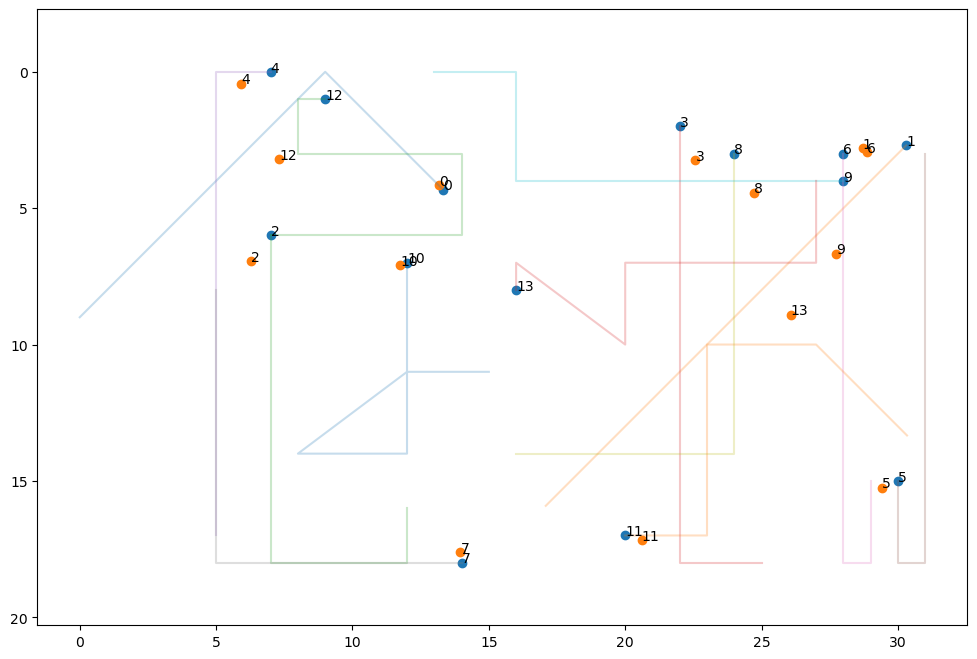

In [34]:
visualize(front_pocket_loader, prep_valid_traj['front_pocket'], got_imu=True, calibrate=True)

In [29]:
# visualize(horizontal_loader, prep_valid_horizontal_traj)

In [30]:
# visualize(c_horizontal_loader, cali_valid_horizontal_traj)

(674, 2) (674, 2) (674,) (674, 20, 17)
Mean: 11.132	Median: 10.617


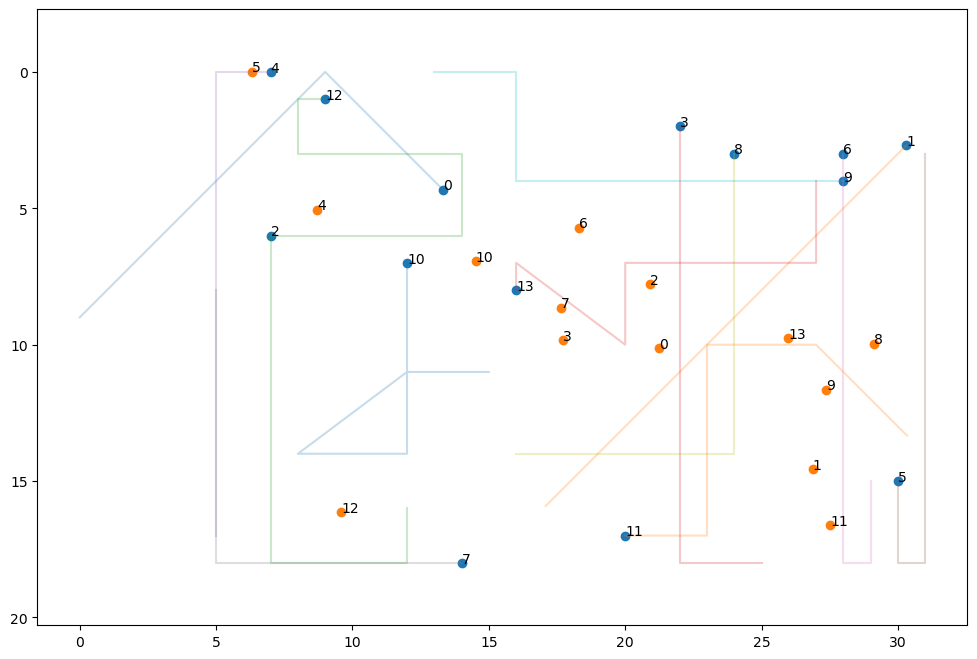

In [35]:
visualize(pocket_loader, prep_valid_traj['pocket'], got_imu=True, calibrate=False)

(674, 2) (674, 2) (674,) (674, 20, 17)
Mean:  2.077	Median:  0.854


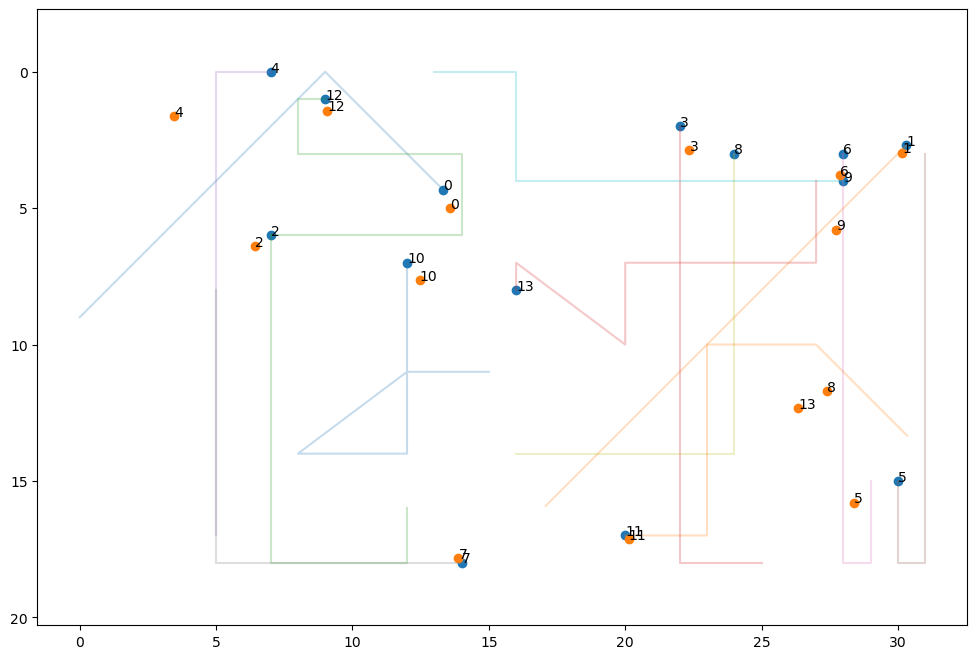

In [36]:
visualize(pocket_loader, prep_valid_traj['pocket'], got_imu=True, calibrate=True)

(674, 2) (674, 2) (674,) (674, 20, 17)
Mean: 12.274	Median: 11.445


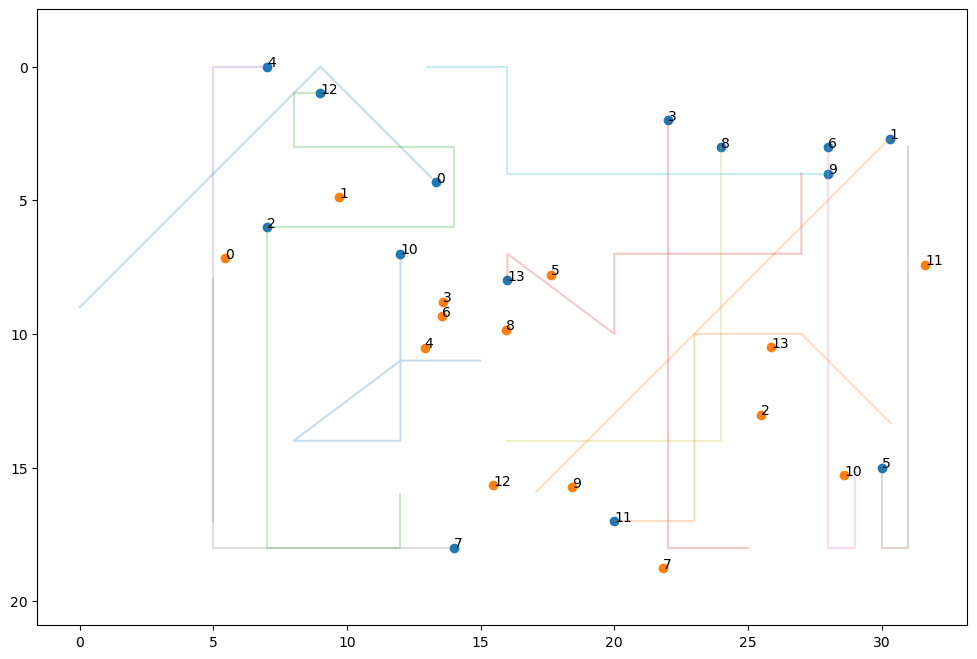

In [37]:
visualize(swing_loader, prep_valid_traj['swing'], got_imu=True, calibrate=False)

(674, 2) (674, 2) (674,) (674, 20, 17)
Mean:  1.971	Median:  0.773


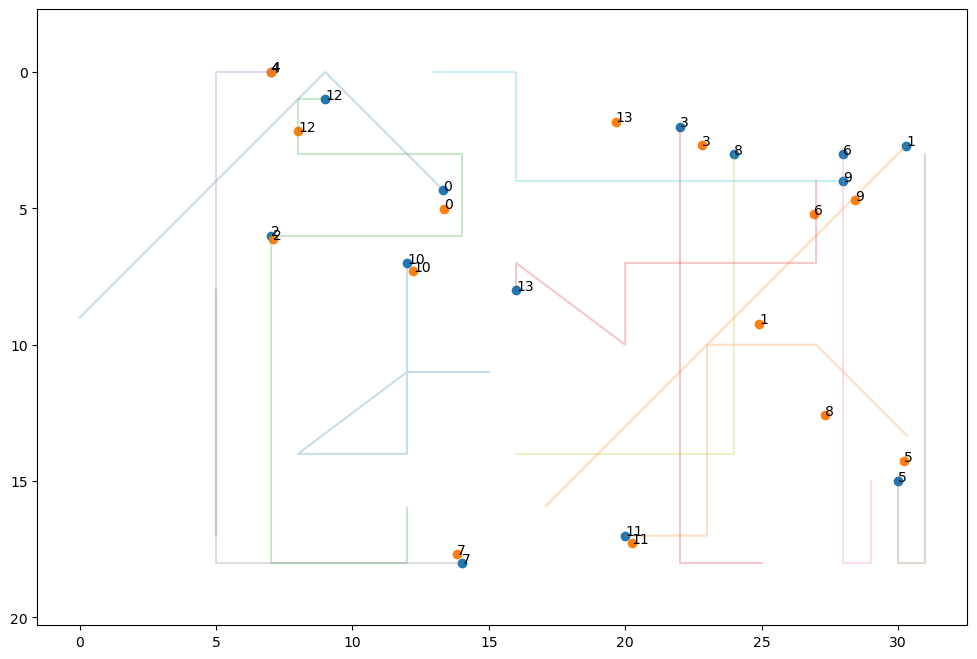

In [38]:
visualize(swing_loader, prep_valid_traj['swing'], got_imu=True, calibrate=True)

(674, 2) (674, 2) (674,) (674, 20, 17)
Mean: 12.871	Median: 12.472


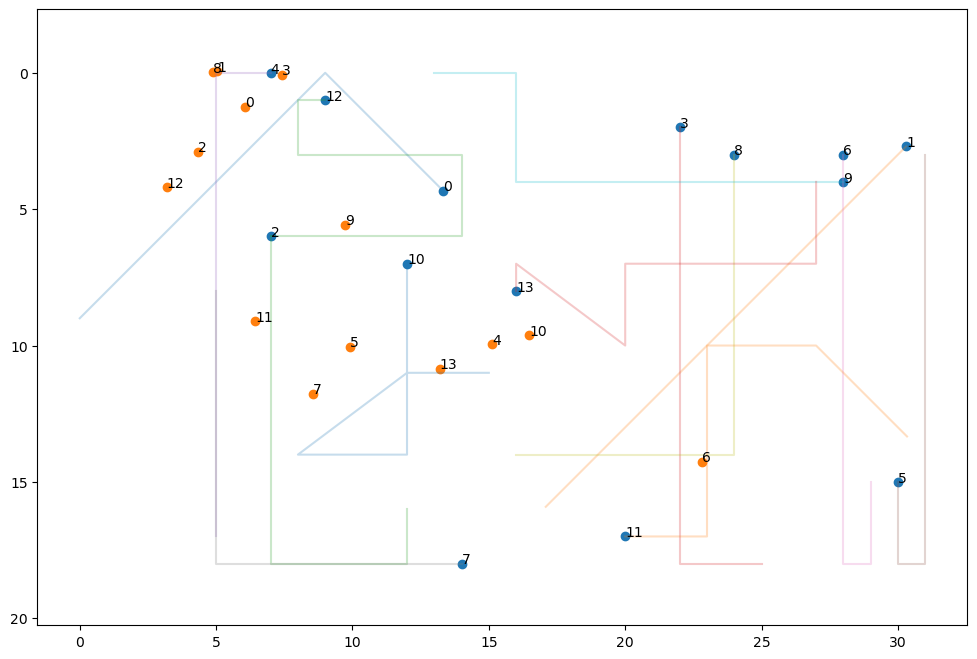

In [39]:
visualize(target_loader, prep_valid_traj['target'], got_imu=True, calibrate=False)

(674, 2) (674, 2) (674,) (674, 20, 17)
Mean:  2.060	Median:  0.880


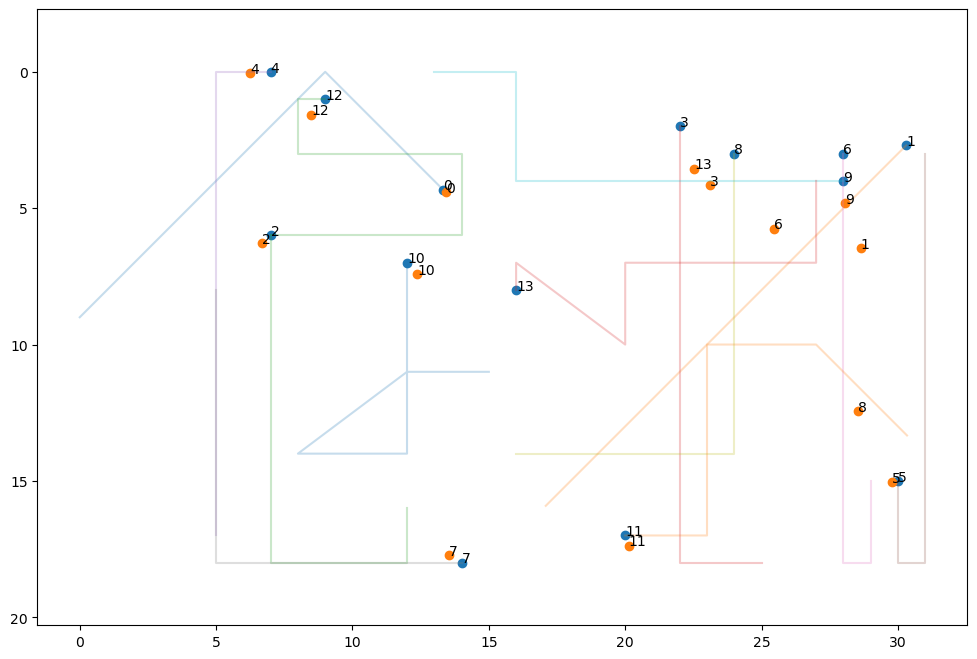

In [40]:
visualize(target_loader, prep_valid_traj['target'], got_imu=True, calibrate=True)

In [42]:
def check_curve(a, b):
    fig = plt.figure(figsize=(15, 5))
    x = np.arange(20)  
    for pm, tm, caxis, color in zip(a.T, b.T, ['x', 'y', 'z', 'H', 'T'], ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple','tab:red']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    plt.legend()
    plt.show()

In [43]:
pp = nn.PairwiseDistance(p=2)

In [44]:
def check_data(source_d, imu_d, ref_d):
    with torch.no_grad():
        _, source_d = calibration(imu_d, source_d[:, :, 0:3])
        rss = torch.sqrt(torch.sum(torch.pow(source_d[:, :, 0:2], 2), dim=2, keepdim=True))
        rss2 = torch.sqrt(torch.sum(torch.pow(source_d[:, :, 0:3], 2), dim=2, keepdim=True))
        source_d = torch.cat((source_d, rss, rss2), dim=2)
        ratio = source_d[:, :, 3] / source_d[:, :, 4]
        acos_values = torch.acos(ratio)
        degrees = acos_values * 180 / torch.pi
        degrees = degrees.unsqueeze(2)
        source_d = torch.cat((source_d, degrees), dim=2)
        pos_s, pos_r = model(source_d), model(ref_d[:, :, 2:])
        pair = pp(pos_s, pos_r)
        s2gt, r2gt = pp(pos_s, ref_d[:, -1, :2]), pp(pos_r, ref_d[:, -1, :2])
        
    source_d = source_d.cpu().numpy()
    ref_d = ref_d.cpu().numpy()
    pos_s, pos_r = pos_s.cpu().numpy(), pos_r.cpu().numpy()
    pair = pair.cpu().numpy()
    s2gt = s2gt.cpu().numpy()
    r2gt = r2gt.cpu().numpy()
    
    check_curve(source_d, ref_d[:, :, 2:])
    print(f'Source Pos: {pos_s}, Ref Pos: {pos_r}\nDistance: [S2R: {pair[0]:>5.3f}, S2GT: {s2gt[0]:>5.3f}, R2GT: {r2gt[0]:>5.3f}]', end='\t')

In [45]:
from time import sleep

for i, j in zip(prep_valid_traj['target'], prep_valid_traj['ref_mag']):
    assert i[-1, 0] == j[-1, 0] and i[-1, 1] == i[-1, 1], print(i[:, 0:2], '\n\n',j[:, 0:2])
    gt = j[-1, 0:2]
    i = torch.tensor(i, dtype=torch.float, device=device).unsqueeze(0)
    j = torch.tensor(j, dtype=torch.float, device=device).unsqueeze(0)
    check_data(i[:, :, 13:15], i[:, :, 2:11], j[:, :, 4:6])
    print(f'GT: {gt}')
    sleep(5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x3 and 2x16)